In [1]:
import scipy.io
import pandas as pd
from PIL import Image
import numpy as np

# Split the Data into Train/Validation/Test (60/20/20)

In [22]:
import shutil
import os

base_path = "./Data/Celebrity Faces Dataset/"
train_path = "Train/"
test_path = "Test/"
validation_path = "Validation/"

# Already ran, do not run again
assert False

for celebrity in os.listdir(base_path):
    if celebrity not in ["Test", "Train", "Validation"]:
        images = os.listdir(base_path + celebrity)
        split_1 = int(.6 * len(images))
        split_2 = split_1 + int(.2 * len(images))
        for image in images[:split_1]:
            if not os.path.exists(f"{base_path}{train_path}{celebrity}"):
                os.mkdir(f"{base_path}{train_path}{celebrity}")
            shutil.move(f"{base_path}{celebrity}/{image}", f"{base_path}{train_path}{celebrity}/{image}")
        for image in images[split_1:split_2]:
            if not os.path.exists(f"{base_path}{test_path}{celebrity}"):
                os.mkdir(f"{base_path}{test_path}{celebrity}")
            shutil.move(f"{base_path}{celebrity}/{image}", f"{base_path}{test_path}{celebrity}/{image}")
        for image in images[split_2:]:
            if not os.path.exists(f"{base_path}{validation_path}{celebrity}"):
                os.mkdir(f"{base_path}{validation_path}{celebrity}")
            shutil.move(f"{base_path}{celebrity}/{image}", f"{base_path}{validation_path}{celebrity}/{image}")

# Raw Models

## VGG16

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

use_gpu = True
if use_gpu and torch.cuda.is_available():
    print("Using CUDA")
else:
    use_gpu = False
    print("Using CPU")

Using CUDA


In [2]:
target_image_width, target_image_height = (224, 224)

train_image_path = "./Data/Celebrity Faces Dataset/Train"
validation_image_path = "./Data/Celebrity Faces Dataset/Validation"
test_image_path = "./Data/Celebrity Faces Dataset/Test"

data_transforms = {
    "Train": transforms.Compose([
        transforms.RandomResizedCrop((target_image_height, target_image_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "Validation" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ]),
    "Test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    "Train": datasets.ImageFolder(
        train_image_path, 
        transform=data_transforms["Train"]
    ),
    "Validation": datasets.ImageFolder(
        validation_image_path, 
        transform=data_transforms["Validation"]
    ),
    "Test": datasets.ImageFolder(
        test_image_path, 
        transform=data_transforms["Test"]
    )
}

dataloaders = {
    "Train": torch.utils.data.DataLoader(
        image_datasets["Train"],
        shuffle=True,
        batch_size=1
    ),
    "Validation": torch.utils.data.DataLoader(
        image_datasets["Validation"],
        shuffle=True,
        batch_size=1
    ),
    "Test": torch.utils.data.DataLoader(
        image_datasets["Test"],
        shuffle=True
    )
}

print("Train Size:", len(image_datasets["Train"]))
print("Validation Size:", len(image_datasets["Validation"]))
print("Test Size:", len(image_datasets["Test"]))
print("Classes:", f'{len(image_datasets["Train"].classes)} Total Classes\n', image_datasets["Train"].classes)

Train Size: 1101
Validation Size: 350
Test Size: 346
Classes: 17 Total Classes
 ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [3]:
vgg16 = models.vgg16_bn(pretrained=True)

# No more training for the VGG model, only need to train classifier
for param in vgg16.features.parameters():
    param.require_grad = False
    
model_in_features = vgg16.classifier[6].in_features
num_classes = len(image_datasets["Train"].classes)
features = list(vgg16.classifier.children())[:-1]
features.append(nn.Linear(model_in_features, num_classes))
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

print(vgg16)

C:\Users\steph\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [60]:
def train_model(model, loss_func, optimizer, num_epochs=20):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    validation_history, loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')
        
        loss_train = 0
        accuracy_validation = 0
        
        model.train(True)
        
        for batch_idx, data in enumerate(dataloaders["Train"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
        
        model.train(True)
        model.eval()
        
        for batch_idx, data in enumerate(dataloaders["Validation"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
        
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            accuracy_validation += torch.sum(predictions == labels.data)
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
            
        loss_history.append(loss_train / len(image_datasets["Train"]))
        validation_history.append(accuracy_validation / len(image_datasets["Validation"]))
        print(f'Training Loss: {loss_train / len(image_datasets["Train"])}')
        print(f'Validation Accuracy: {accuracy_validation / len(image_datasets["Validation"])}')
        print("===================================================")
        
        if accuracy_validation / len(image_datasets["Validation"]) > best_accuracy:
            best_accuracy = accuracy_validation / len(image_datasets["Validation"])
            best_model_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_weights)
    return model, loss_history, validation_history

In [61]:
if use_gpu:
    vgg16.cuda()
    
lr = 1e-4
momentum = 0.9
step_size = 5
gamma = 0.1
    
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=lr, momentum=momentum)
trained_vgg, loss_history, validation_history = train_model(vgg16, loss, optimizer, num_epochs=20)

Epoch 0/20
Training Loss: 2.8414169373455964
Validation Accuracy: 0.11428571492433548
Epoch 1/20
Training Loss: 2.8019332493791573
Validation Accuracy: 0.1257142871618271
Epoch 2/20
Training Loss: 2.727849415602411
Validation Accuracy: 0.1314285695552826
Epoch 3/20
Training Loss: 2.411675309885858
Validation Accuracy: 0.1971428543329239
Epoch 4/20
Training Loss: 2.160452755322032
Validation Accuracy: 0.2742857038974762
Epoch 5/20
Training Loss: 1.9482652951204484
Validation Accuracy: 0.3142857253551483
Epoch 6/20
Training Loss: 1.735647235221342
Validation Accuracy: 0.3514285683631897
Epoch 7/20
Training Loss: 1.4742199833167347
Validation Accuracy: 0.3400000035762787
Epoch 8/20
Training Loss: 1.402531053087307
Validation Accuracy: 0.4000000059604645
Epoch 9/20
Training Loss: 1.245141489645483
Validation Accuracy: 0.48571428656578064
Epoch 10/20
Training Loss: 1.1516427825390383
Validation Accuracy: 0.5057142972946167
Epoch 11/20
Training Loss: 1.0731018316313679
Validation Accuracy: 0

In [56]:
torch.save(trained_vgg.state_dict(), "./Trained Models/vgg16_no_pretrained.pt")

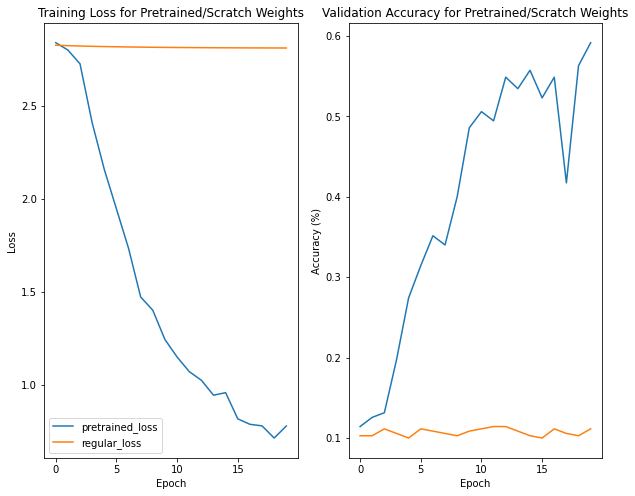

In [99]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

axes[0].plot(list(range(20)), loss_history, label="pretrained_loss")
axes[0].plot(list(range(20)), no_pretrained_loss, label="regular_loss")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss for Pretrained/Scratch Weights")

axes[0].legend()

axes[1].plot(list(range(20)), [item.item() for item in validation_history], label="pretrained_validation")
axes[1].plot(list(range(20)), [item.item() for item in no_pretrained_validation], label="regular_validation")

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy for Pretrained/Scratch Weights")

plt.show()

In [4]:
def evaluate_model(model, loss_function):
    loss_test = 0
    acc_test = 0
    
    for index, data in enumerate(dataloaders["Test"]):
        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        
        loss = loss_function(outputs, labels)
        
        loss_test += loss.item()
        acc_test += torch.sum(predictions == labels.data)
        
        del inputs, labels, outputs, predictions
        torch.cuda.empty_cache()
    
    print(f"Average loss: {loss_test / len(image_datasets['Test'])}")
    print(f"Average accuracy: {acc_test / len(image_datasets['Test'])}")

In [7]:
vgg16.load_state_dict(torch.load("./Trained Models/vgg16_no_pretrained.pt"))
if use_gpu:
    vgg16.cuda()
    
loss = nn.CrossEntropyLoss()

evaluate_model(vgg16, loss)

C:\Users\steph\AppData\Local\Temp\ipykernel_9892\1433928459.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Average loss: 2.9443293375775994
Average accuracy: 0.11271676421165466


# Resnet101

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

use_gpu = True
if use_gpu and torch.cuda.is_available():
    print("Using CUDA")
else:
    use_gpu = False
    print("Using CPU")

Using CUDA


In [12]:
target_image_width, target_image_height = (224, 224)

train_image_path = "./Data/Celebrity Faces Dataset/Train"
validation_image_path = "./Data/Celebrity Faces Dataset/Validation"
test_image_path = "./Data/Celebrity Faces Dataset/Test"

data_transforms = {
    "Train": transforms.Compose([
        transforms.RandomResizedCrop((target_image_height, target_image_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "Validation" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ]),
    "Test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    "Train": datasets.ImageFolder(
        train_image_path, 
        transform=data_transforms["Train"]
    ),
    "Validation": datasets.ImageFolder(
        validation_image_path, 
        transform=data_transforms["Validation"]
    ),
    "Test": datasets.ImageFolder(
        test_image_path, 
        transform=data_transforms["Test"]
    )
}

dataloaders = {
    "Train": torch.utils.data.DataLoader(
        image_datasets["Train"],
        shuffle=True,
        batch_size=1
    ),
    "Validation": torch.utils.data.DataLoader(
        image_datasets["Validation"],
        shuffle=True,
        batch_size=1
    ),
    "Test": torch.utils.data.DataLoader(
        image_datasets["Test"],
        shuffle=True
    )
}

print("Train Size:", len(image_datasets["Train"]))
print("Validation Size:", len(image_datasets["Validation"]))
print("Test Size:", len(image_datasets["Test"]))
print("Classes:", f'{len(image_datasets["Train"].classes)} Total Classes\n', image_datasets["Train"].classes)

Train Size: 1101
Validation Size: 350
Test Size: 346
Classes: 17 Total Classes
 ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [17]:
def train_model(model, loss_func, optimizer, num_epochs=20):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    validation_history, loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')
        
        loss_train = 0
        accuracy_validation = 0
        
        model.train(True)
        
        for batch_idx, data in enumerate(dataloaders["Train"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
        
        model.train(True)
        model.eval()
        
        for batch_idx, data in enumerate(dataloaders["Validation"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
        
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            accuracy_validation += torch.sum(predictions == labels.data)
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
            
        loss_history.append(loss_train / len(image_datasets["Train"]))
        validation_history.append(accuracy_validation / len(image_datasets["Validation"]))
        print(f'Training Loss: {loss_train / len(image_datasets["Train"])}')
        print(f'Validation Accuracy: {accuracy_validation / len(image_datasets["Validation"])}')
        print("===================================================")
        
        if accuracy_validation / len(image_datasets["Validation"]) > best_accuracy:
            best_accuracy = accuracy_validation / len(image_datasets["Validation"])
            best_model_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_weights)
    return model, loss_history, validation_history

In [13]:
resnet101 = models.resnet101(pretrained=False)

for param in resnet101.parameters():
    param.requires_grad = False
        
in_features = resnet101.fc.in_features
num_classes = len(image_datasets["Train"].classes)

resnet101.fc = nn.Linear(in_features, num_classes)
print(resnet101)

C:\Users\steph\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
if use_gpu:
    resnet101.cuda()
    
lr = 1e-3
momentum = 0.9
step_size = 5
gamma = 0.1

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet101.parameters(), lr=lr, momentum=momentum)

trained_vgg, loss_history, validation_history = train_model(resnet101, loss, optimizer, num_epochs=20)

Epoch 0/20
Training Loss: 10.737018099648084
Validation Accuracy: 0.05999999865889549
Epoch 1/20
Training Loss: 11.468058173461703
Validation Accuracy: 0.05714285746216774
Epoch 2/20
Training Loss: 11.304670222089005
Validation Accuracy: 0.04571428522467613
Epoch 3/20
Training Loss: 11.341667615275849
Validation Accuracy: 0.04285714402794838
Epoch 4/20
Training Loss: 10.74717769794315
Validation Accuracy: 0.0771428570151329
Epoch 5/20
Training Loss: 10.845376802559164
Validation Accuracy: 0.0714285671710968
Epoch 6/20
Training Loss: 11.149142438202075
Validation Accuracy: 0.05714285746216774
Epoch 7/20
Training Loss: 11.218637229459612
Validation Accuracy: 0.10285714268684387
Epoch 8/20
Training Loss: 11.622639419298569
Validation Accuracy: 0.051428571343421936
Epoch 9/20
Training Loss: 11.77635013496304
Validation Accuracy: 0.05714285746216774
Epoch 10/20
Training Loss: 10.706203072416857
Validation Accuracy: 0.0714285671710968
Epoch 11/20
Training Loss: 11.642177124344213
Validation 

In [23]:
torch.save(trained_vgg.state_dict(), "./Trained Models/resnet101_no_pretrained.pt")

In [20]:
pretrained_loss_history, pretrained_validation_history = loss_history, validation_history

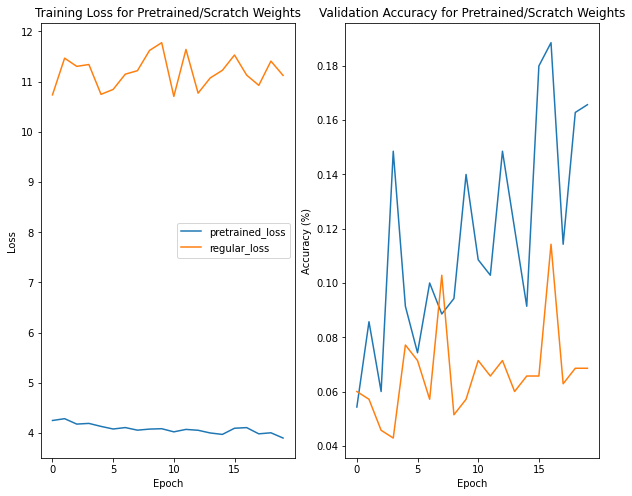

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

axes[0].plot(list(range(20)), pretrained_loss_history, label="pretrained_loss")
axes[0].plot(list(range(20)), loss_history, label="regular_loss")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss for Pretrained/Scratch Weights")

axes[0].legend()

axes[1].plot(list(range(20)), [item.item() for item in pretrained_validation_history], label="pretrained_validation")
axes[1].plot(list(range(20)), [item.item() for item in validation_history], label="regular_validation")

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy for Pretrained/Scratch Weights")

plt.show()

In [8]:
def evaluate_model(model, loss_function):
    loss_test = 0
    acc_test = 0
    
    for index, data in enumerate(dataloaders["Test"]):
        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        
        loss = loss_function(outputs, labels)
        
        loss_test += loss.item()
        acc_test += torch.sum(predictions == labels.data)
        
        del inputs, labels, outputs, predictions
        torch.cuda.empty_cache()
    
    print(f"Average loss: {loss_test / len(image_datasets['Test'])}")
    print(f"Average accuracy: {acc_test / len(image_datasets['Test'])}")

In [14]:
resnet101.load_state_dict(torch.load("./Trained Models/resnet101_no_pretrained.pt"))

if use_gpu:
    resnet101.cuda()
    

loss = nn.CrossEntropyLoss()

evaluate_model(resnet101, loss)

C:\Users\steph\AppData\Local\Temp\ipykernel_9892\1433928459.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Average loss: 14.254388711797807
Average accuracy: 0.1184971034526825


# MTCNN Models
## MTCNN Face Cropping

In [18]:
import cv2
from mtcnn import MTCNN
from PIL import Image

def crop_face(filename, target_size=(224, 224)):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mtcnn_face_detector = MTCNN()
    result = mtcnn_face_detector.detect_faces(image)
    if not result:
        return None
    x, y, width, height = result[0]['box']
    face = image[y:y+height, x:x+width]
    cropped_image = Image.fromarray(face)
    cropped_image = cropped_image.resize(target_size)
    return cropped_image

In [35]:
import os

base_path = "./Data/Celebrity Faces Dataset"

# Already ran, do not run again
assert False

for data_type in os.listdir(base_path):
    if data_type != "MTCNN_Cropped_Faces":
        for celebrity in os.listdir(f"{base_path}/{data_type}"):
            for celebrity_image in os.listdir(f"{base_path}/{data_type}/{celebrity}"):
                cropped_image = crop_face(f"{base_path}/{data_type}/{celebrity}/{celebrity_image}")
                if not cropped_image:
                    continue
                if not os.path.exists(f"{base_path}/MTCNN_Cropped_Faces/{data_type}/{celebrity}"):
                    os.makedirs(f"{base_path}/MTCNN_Cropped_Faces/{data_type}/{celebrity}")
                cropped_image.save(f"{base_path}/MTCNN_Cropped_Faces/{data_type}/{celebrity}/{celebrity_image}")

AssertionError: 

## VGGFace (VGG16)

In [28]:
from keras_vggface.vggface import VGGFace

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D, Dense, Dropout, Flatten, Activation

num_class = 17

vggface_model = VGGFace(model='vgg16', weights='vggface', input_shape=(224, 224, 3), pooling='avg', include_top=False)
classifier = Sequential([
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_class, activation='softmax')])

vggface_vgg16_model = Sequential([vggface_model, classifier])
vggface_vgg16_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy']
)
vggface_vgg16_model.layers[0].trainable = False

In [24]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input

base_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces"
target_image_width, target_image_height = 224, 224

classes = os.listdir(f"{base_path}/Train")

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

traingen = train_generator.flow_from_directory(
    f"{base_path}/Train",
    target_size=(target_image_width, target_image_height),
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

validgen = test_generator.flow_from_directory(
    f"{base_path}/Validation",
    target_size=(target_image_width, target_image_height),
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

testgen = test_generator.flow_from_directory(
    f"{base_path}/Test",
    target_size=(target_image_width, target_image_height),
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

Found 1081 images belonging to 17 classes.
Found 349 images belonging to 17 classes.
Found 333 images belonging to 17 classes.


In [30]:
input_shape = (224, 224, 3)
epochs = 10

history = vggface_vgg16_model.fit(
    traingen,
    epochs=epochs,
    validation_data=validgen,
    verbose=1
)

Epoch 1/10
34/34 [==============================] - 367s 11s/step - loss: 2.6026 - accuracy: 0.1739 - categorical_crossentropy: 2.6026 - val_loss: 1.1276 - val_accuracy: 0.6533 - val_categorical_crossentropy: 1.1276
Epoch 2/10
34/34 [==============================] - 366s 11s/step - loss: 2.3094 - accuracy: 0.2710 - categorical_crossentropy: 2.3094 - val_loss: 1.0607 - val_accuracy: 0.6991 - val_categorical_crossentropy: 1.0607
Epoch 3/10
34/34 [==============================] - 367s 11s/step - loss: 2.2431 - accuracy: 0.2720 - categorical_crossentropy: 2.2431 - val_loss: 1.3705 - val_accuracy: 0.7307 - val_categorical_crossentropy: 1.3705
Epoch 4/10
34/34 [==============================] - 366s 11s/step - loss: 2.2263 - accuracy: 0.3025 - categorical_crossentropy: 2.2263 - val_loss: 0.4261 - val_accuracy: 0.8825 - val_categorical_crossentropy: 0.4261
Epoch 5/10
34/34 [==============================] - 366s 11s/step - loss: 1.9813 - accuracy: 0.3608 - categorical_crossentropy: 1.9813 -

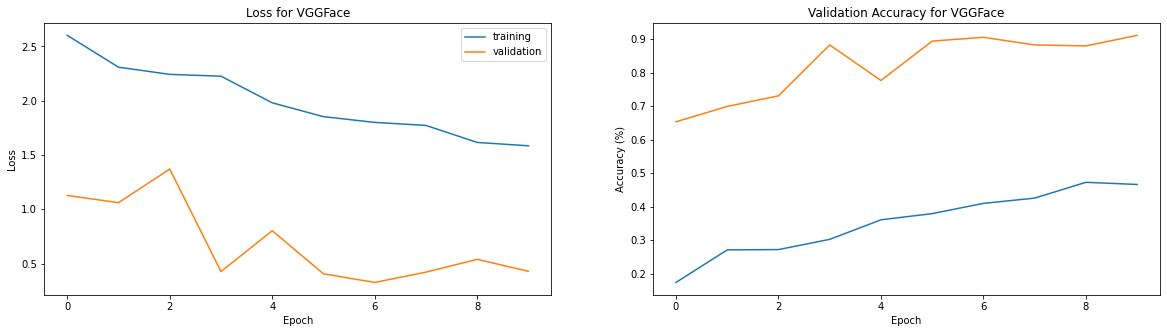

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(list(range(10)), history.history["loss"], label="training")
axes[0].plot(list(range(10)), history.history["val_loss"], label="validation")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss for VGGFace")

axes[0].legend()

axes[1].plot(list(range(10)), history.history["accuracy"], label="pretrained_validation")
axes[1].plot(list(range(10)), history.history["val_accuracy"], label="regular_validation")

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy for VGGFace")

plt.show()

In [90]:
vggface_vgg16_model.evaluate(testgen)

11/11 [==============================] - 29s 3s/step - loss: 0.5818 - accuracy: 0.9099 - categorical_crossentropy: 0.5818


[0.5817863345146179, 0.9099099040031433, 0.5817863345146179]

In [92]:
vggface_vgg16_model.save("./Trained Models/vggface_vgg16.h5")

## VGGFace (Resnet50)

In [1]:
from keras_vggface.vggface import VGGFace

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

num_class = 17

vggface_model = VGGFace(model='resnet50', weights='vggface', input_shape=(224, 224, 3), pooling='avg', include_top=False)
classifier = Sequential([
    Flatten(),
    Dense(num_class, activation='softmax')])

vggface_resnet50_model = Sequential([vggface_model, classifier])
vggface_resnet50_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy']
)
vggface_resnet50_model.layers[0].trainable = False
print(vggface_resnet50_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_resnet50 (Functiona  (None, 2048)             23561152  
 l)                                                              
                                                                 
 sequential (Sequential)     (None, 17)                34833     
                                                                 
Total params: 23,595,985
Trainable params: 34,833
Non-trainable params: 23,561,152
_________________________________________________________________
None


In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input

base_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces"
target_image_width, target_image_height = 224, 224

classes = os.listdir(f"{base_path}/Train")

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function=lambda x : preprocess_input(x, version=2))

test_generator = ImageDataGenerator(preprocessing_function=lambda x : preprocess_input(x, version=2))

traingen = train_generator.flow_from_directory(
    f"{base_path}/Train",
    target_size=(target_image_width, target_image_height),
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

validgen = test_generator.flow_from_directory(
    f"{base_path}/Validation",
    target_size=(target_image_width, target_image_height),
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

testgen = test_generator.flow_from_directory(
    f"{base_path}/Test",
    target_size=(target_image_width, target_image_height),
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

Found 1081 images belonging to 17 classes.
Found 349 images belonging to 17 classes.
Found 333 images belonging to 17 classes.


In [3]:
input_shape = (224, 224, 3)
epochs = 10

history = vggface_resnet50_model.fit(
    traingen,
    epochs=epochs,
    validation_data=validgen,
    verbose=1
)

Epoch 1/10
34/34 [==============================] - 248s 7s/step - loss: 4.0343 - accuracy: 0.1563 - categorical_crossentropy: 4.0343 - val_loss: 109.0087 - val_accuracy: 0.0573 - val_categorical_crossentropy: 109.0087
Epoch 2/10
34/34 [==============================] - 233s 7s/step - loss: 2.2199 - accuracy: 0.3210 - categorical_crossentropy: 2.2199 - val_loss: 1.2232 - val_accuracy: 0.6332 - val_categorical_crossentropy: 1.2232
Epoch 3/10
34/34 [==============================] - 239s 7s/step - loss: 1.7500 - accuracy: 0.4329 - categorical_crossentropy: 1.7500 - val_loss: 38.5851 - val_accuracy: 0.3123 - val_categorical_crossentropy: 38.5851
Epoch 4/10
34/34 [==============================] - 228s 7s/step - loss: 1.4082 - accuracy: 0.5421 - categorical_crossentropy: 1.4082 - val_loss: 0.3276 - val_accuracy: 0.8940 - val_categorical_crossentropy: 0.3276
Epoch 5/10
34/34 [==============================] - 234s 7s/step - loss: 1.3620 - accuracy: 0.5523 - categorical_crossentropy: 1.3620 

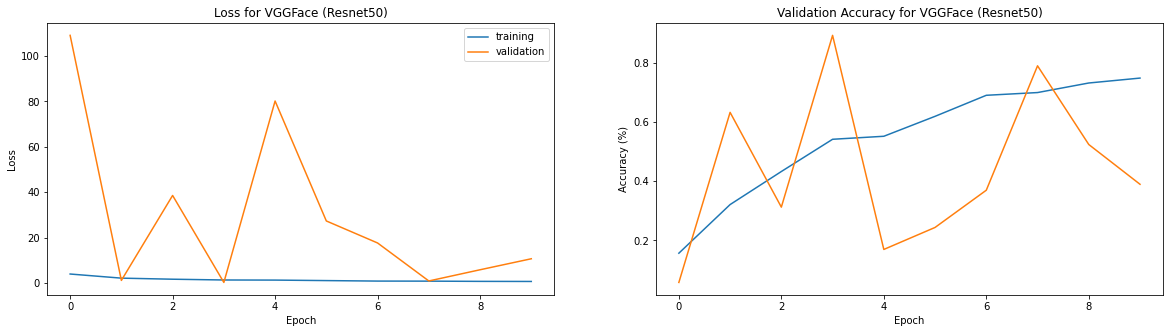

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(list(range(10)), history.history["loss"], label="training")
axes[0].plot(list(range(10)), history.history["val_loss"], label="validation")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss for VGGFace (Resnet50)")

axes[0].legend()

axes[1].plot(list(range(10)), history.history["accuracy"], label="pretrained_validation")
axes[1].plot(list(range(10)), history.history["val_accuracy"], label="regular_validation")

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy for VGGFace (Resnet50)")

plt.show()

In [6]:
vggface_resnet50_model.evaluate(testgen)

11/11 [==============================] - 12s 1s/step - loss: 11.1548 - accuracy: 0.3874 - categorical_crossentropy: 11.1548


[11.154830932617188, 0.38738739490509033, 11.154830932617188]

In [5]:
vggface_resnet50_model.save("./Trained Models/vggface_resnet50.h5")

## DeepFace

## VGG16 (again..)

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

use_gpu = True
if use_gpu and torch.cuda.is_available():
    print("Using CUDA")
else:
    use_gpu = False
    print("Using CPU")

Using CUDA


In [68]:
target_image_width, target_image_height = (224, 224)

train_image_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Train"
validation_image_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Validation"
test_image_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Test"

data_transforms = {
    "Train": transforms.Compose([
        transforms.RandomResizedCrop((target_image_height, target_image_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "Validation" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ]),
    "Test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    "Train": datasets.ImageFolder(
        train_image_path, 
        transform=data_transforms["Train"]
    ),
    "Validation": datasets.ImageFolder(
        validation_image_path, 
        transform=data_transforms["Validation"]
    ),
    "Test": datasets.ImageFolder(
        test_image_path, 
        transform=data_transforms["Test"]
    )
}

dataloaders = {
    "Train": torch.utils.data.DataLoader(
        image_datasets["Train"],
        shuffle=True,
        batch_size=1
    ),
    "Validation": torch.utils.data.DataLoader(
        image_datasets["Validation"],
        shuffle=True,
        batch_size=1
    ),
    "Test": torch.utils.data.DataLoader(
        image_datasets["Test"],
        shuffle=True
    )
}

print("Train Size:", len(image_datasets["Train"]))
print("Validation Size:", len(image_datasets["Validation"]))
print("Test Size:", len(image_datasets["Test"]))
print("Classes:", f'{len(image_datasets["Train"].classes)} Total Classes\n', image_datasets["Train"].classes)

Train Size: 1081
Validation Size: 349
Test Size: 333
Classes: 17 Total Classes
 ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [44]:
vgg16 = models.vgg16_bn(pretrained=True)

# No more training for the VGG model, only need to train classifier
for param in vgg16.features.parameters():
    param.require_grad = False
    
model_in_features = vgg16.classifier[6].in_features
num_classes = len(image_datasets["Train"].classes)
features = list(vgg16.classifier.children())[:-1]
features.append(nn.Linear(model_in_features, num_classes))
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

C:\Users\steph\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steph\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
def train_model(model, loss_func, optimizer, num_epochs=20):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    validation_history, loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')
        
        loss_train = 0
        accuracy_validation = 0
        
        model.train(True)
        
        for batch_idx, data in enumerate(dataloaders["Train"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
        
        model.train(True)
        model.eval()
        
        for batch_idx, data in enumerate(dataloaders["Validation"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
        
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            accuracy_validation += torch.sum(predictions == labels.data)
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
            
        loss_history.append(loss_train / len(image_datasets["Train"]))
        validation_history.append(accuracy_validation / len(image_datasets["Validation"]))
        print(f'Training Loss: {loss_train / len(image_datasets["Train"])}')
        print(f'Validation Accuracy: {accuracy_validation / len(image_datasets["Validation"])}')
        print("===================================================")
        
        if accuracy_validation / len(image_datasets["Validation"]) > best_accuracy:
            best_accuracy = accuracy_validation / len(image_datasets["Validation"])
            best_model_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_weights)
    return model, loss_history, validation_history

In [86]:
if use_gpu:
    vgg16.cuda()
    
lr = 1e-4
momentum = 0.9
step_size = 5
gamma = 0.1
    
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=lr, momentum=momentum)
trained_vgg, loss_history, validation_history = train_model(vgg16, loss, optimizer, num_epochs=20)

Epoch 0/20
Training Loss: 0.6779359842166943
Validation Accuracy: 0.4985673427581787
Epoch 1/20
Training Loss: 0.6845971174092337
Validation Accuracy: 0.5300859808921814
Epoch 2/20
Training Loss: 0.6993170899644523
Validation Accuracy: 0.42120346426963806
Epoch 3/20
Training Loss: 0.6405902547288723
Validation Accuracy: 0.43266478180885315
Epoch 4/20
Training Loss: 0.6281671052646971
Validation Accuracy: 0.3782235085964203
Epoch 5/20
Training Loss: 0.5299194882890768
Validation Accuracy: 0.4183381199836731
Epoch 6/20
Training Loss: 0.6036249061061493
Validation Accuracy: 0.4985673427581787
Epoch 7/20
Training Loss: 0.5836236568909974
Validation Accuracy: 0.4871060252189636
Epoch 8/20
Training Loss: 0.5426542903561761
Validation Accuracy: 0.4183381199836731
Epoch 9/20
Training Loss: 0.5371304045554274
Validation Accuracy: 0.45272207260131836
Epoch 10/20
Training Loss: 0.560062603793134
Validation Accuracy: 0.5214899778366089
Epoch 11/20
Training Loss: 0.5349089950415419
Validation Accur

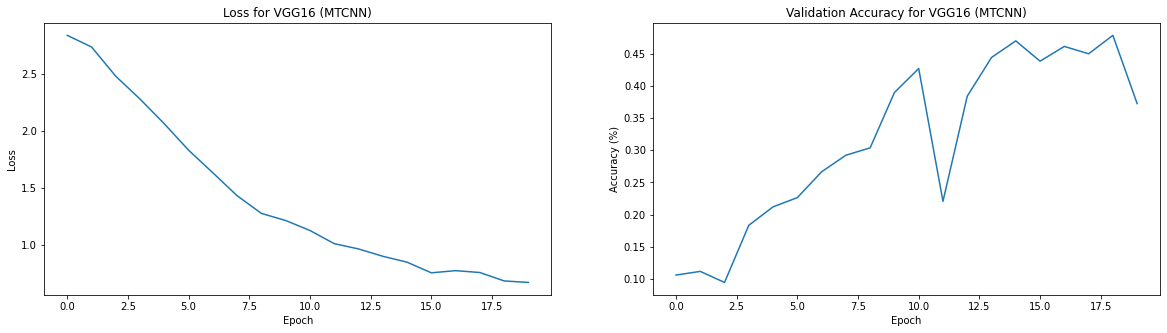

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(list(range(20)), loss_history)

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss for VGG16 (MTCNN)")

axes[1].plot(list(range(20)), [item.item() for item in validation_history])

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy for VGG16 (MTCNN)")

plt.show()

In [87]:
def evaluate_model(model, loss_function):
    loss_test = 0
    acc_test = 0
    
    for index, data in enumerate(dataloaders["Test"]):
        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        
        loss = loss_function(outputs, labels)
        
        loss_test += loss.item()
        acc_test += torch.sum(predictions == labels.data)
        
        del inputs, labels, outputs, predictions
        torch.cuda.empty_cache()
    
    print(f"Average loss: {loss_test / len(image_datasets['Test'])}")
    print(f"Average accuracy: {acc_test / len(image_datasets['Test'])}")

In [88]:
criterion = nn.CrossEntropyLoss()

evaluate_model(trained_vgg, criterion)

C:\Users\steph\AppData\Local\Temp\ipykernel_19320\1433928459.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Average loss: 1.7829957009031798
Average accuracy: 0.5795795917510986


In [89]:
torch.save(trained_vgg.state_dict(), "./Trained Models/vgg16_mtcnn.pt")

## Resnet101 (again..)

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

use_gpu = True
if use_gpu and torch.cuda.is_available():
    print("Using CUDA")
else:
    use_gpu = False
    print("Using CPU")

Using CUDA


In [55]:
target_image_width, target_image_height = (224, 224)

train_image_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Train"
validation_image_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Validation"
test_image_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Test"

data_transforms = {
    "Train": transforms.Compose([
        transforms.RandomResizedCrop((target_image_height, target_image_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "Validation" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ]),
    "Test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((target_image_height, target_image_width)),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    "Train": datasets.ImageFolder(
        train_image_path, 
        transform=data_transforms["Train"]
    ),
    "Validation": datasets.ImageFolder(
        validation_image_path, 
        transform=data_transforms["Validation"]
    ),
    "Test": datasets.ImageFolder(
        test_image_path, 
        transform=data_transforms["Test"]
    )
}

dataloaders = {
    "Train": torch.utils.data.DataLoader(
        image_datasets["Train"],
        shuffle=True,
        batch_size=1
    ),
    "Validation": torch.utils.data.DataLoader(
        image_datasets["Validation"],
        shuffle=True,
        batch_size=1
    ),
    "Test": torch.utils.data.DataLoader(
        image_datasets["Test"],
        shuffle=True
    )
}

print("Train Size:", len(image_datasets["Train"]))
print("Validation Size:", len(image_datasets["Validation"]))
print("Test Size:", len(image_datasets["Test"]))
print("Classes:", f'{len(image_datasets["Train"].classes)} Total Classes\n', image_datasets["Train"].classes)

Train Size: 1081
Validation Size: 349
Test Size: 333
Classes: 17 Total Classes
 ['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [56]:
def train_model(model, loss_func, optimizer, num_epochs=20):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    validation_history, loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')
        
        loss_train = 0
        accuracy_validation = 0
        
        model.train(True)
        
        for batch_idx, data in enumerate(dataloaders["Train"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
        
        model.train(True)
        model.eval()
        
        for batch_idx, data in enumerate(dataloaders["Validation"]):
            optimizer.zero_grad()
            
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
        
            scores = model(inputs)
            _, predictions = torch.max(scores.data, 1)
            loss = loss_func(scores, labels)
            
            accuracy_validation += torch.sum(predictions == labels.data)
            
            del inputs, labels, scores, predictions
            torch.cuda.empty_cache()
            
        loss_history.append(loss_train / len(image_datasets["Train"]))
        validation_history.append(accuracy_validation / len(image_datasets["Validation"]))
        print(f'Training Loss: {loss_train / len(image_datasets["Train"])}')
        print(f'Validation Accuracy: {accuracy_validation / len(image_datasets["Validation"])}')
        print("===================================================")
        
        if accuracy_validation / len(image_datasets["Validation"]) > best_accuracy:
            best_accuracy = accuracy_validation / len(image_datasets["Validation"])
            best_model_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_weights)
    return model, loss_history, validation_history

In [60]:
resnet101 = models.resnet101(pretrained=True)

for param in resnet101.parameters():
    param.requires_grad = False
        
in_features = resnet101.fc.in_features
num_classes = len(image_datasets["Train"].classes)

resnet101.fc = nn.Linear(in_features, num_classes)

C:\Users\steph\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
if use_gpu:
    resnet101.cuda()
    
lr = 1e-3
momentum = 0.9
step_size = 5
gamma = 0.1

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet101.parameters(), lr=lr, momentum=momentum)

trained_resnet101, train_loss_history, validation_history = train_model(resnet101, loss, optimizer, num_epochs=20)

Epoch 0/20
Training Loss: 4.083259361717681
Validation Accuracy: 0.08882521837949753
Epoch 1/20
Training Loss: 4.05315126741958
Validation Accuracy: 0.06876791268587112
Epoch 2/20
Training Loss: 3.958655412616441
Validation Accuracy: 0.06876791268587112
Epoch 3/20
Training Loss: 4.078890205270487
Validation Accuracy: 0.12034384161233902
Epoch 4/20
Training Loss: 3.979641185320438
Validation Accuracy: 0.13753582537174225
Epoch 5/20
Training Loss: 4.0163480064363855
Validation Accuracy: 0.08309455960988998
Epoch 6/20
Training Loss: 4.0296417521752215
Validation Accuracy: 0.09455587714910507
Epoch 7/20
Training Loss: 3.9931781205049717
Validation Accuracy: 0.11461318284273148
Epoch 8/20
Training Loss: 4.043615324259025
Validation Accuracy: 0.06590258330106735
Epoch 9/20
Training Loss: 3.967240800097185
Validation Accuracy: 0.08309455960988998
Epoch 10/20
Training Loss: 3.945061244656376
Validation Accuracy: 0.1518624722957611
Epoch 11/20
Training Loss: 3.8681250817791164
Validation Accura

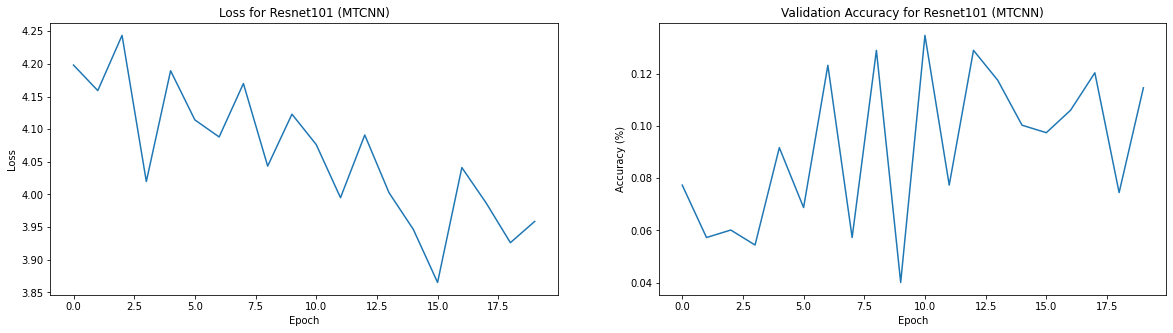

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(list(range(20)), train_loss_history)

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss for Resnet101 (MTCNN)")

axes[1].plot(list(range(20)), [item.item() for item in validation_history])

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Validation Accuracy for Resnet101 (MTCNN)")

plt.show()

In [94]:
def evaluate_model(model, loss_function):
    loss_test = 0
    acc_test = 0
    
    for index, data in enumerate(dataloaders["Test"]):
        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        
        loss = loss_function(outputs, labels)
        
        loss_test += loss.item()
        acc_test += torch.sum(predictions == labels.data)
        
        del inputs, labels, outputs, predictions
        torch.cuda.empty_cache()
    
    print(f"Average loss: {loss_test / len(image_datasets['Test'])}")
    print(f"Average accuracy: {acc_test / len(image_datasets['Test'])}")

In [95]:
criterion = nn.CrossEntropyLoss()

evaluate_model(trained_resnet101, criterion)

C:\Users\steph\AppData\Local\Temp\ipykernel_19320\1433928459.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Average loss: 28.1683421135285
Average accuracy: 0.16816817224025726


In [96]:
torch.save(trained_vgg.state_dict(), "./Trained Models/resnet101_mtcnn.pt")

# Preprocessing Visualization

In [21]:
import cv2
import matplotlib.pyplot as plt

file_path = "./Data/Celebrity Faces Dataset/MTCNN_Cropped_Faces/Test/Tom Hanks/076_66977623.jpg"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


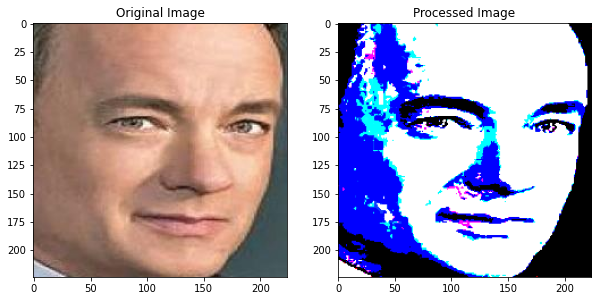

In [34]:
from tensorflow.keras.applications.vgg16 import preprocess_input

fig, axes = plt.subplots(1, 2,figsize=(10, 8))

image = cv2.imread(file_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].title.set_text("Original Image")

image = preprocess_input(image)
axes[1].imshow(image)
axes[1].title.set_text("Processed Image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


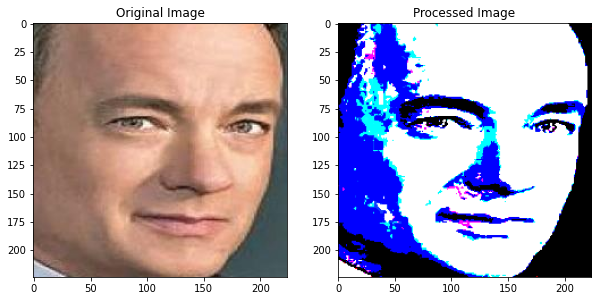

In [35]:
from tensorflow.keras.applications.resnet import preprocess_input

fig, axes = plt.subplots(1, 2,figsize=(10, 8))

image = cv2.imread(file_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].title.set_text("Original Image")

image = preprocess_input(image)
axes[1].imshow(image)
axes[1].title.set_text("Processed Image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


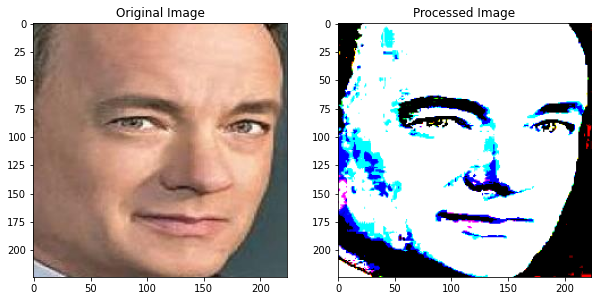

In [43]:
from keras_vggface.utils import preprocess_input

fig, axes = plt.subplots(1, 2,figsize=(10, 8))

image = cv2.imread(file_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].title.set_text("Original Image")

image = image.astype("float64")

image = preprocess_input(image, version=1)
axes[1].imshow(image)
axes[1].title.set_text("Processed Image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


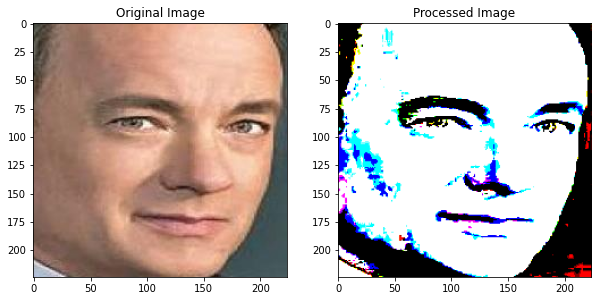

In [44]:
from keras_vggface.utils import preprocess_input

fig, axes = plt.subplots(1, 2,figsize=(10, 8))

image = cv2.imread(file_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].title.set_text("Original Image")

image = image.astype("float64")

image = preprocess_input(image, version=2)
axes[1].imshow(image)
axes[1].title.set_text("Processed Image")